
# 1. Logistic Regression and Random Forest in the credit scoring problem

## 1.1. Credit scoring problem setup

### 1.1.1. Problem

We will predict whether the customer will repay their credit within 90 days. This is a binary classification problem; we will assign customers into good or bad categories based on our prediction.

### 1.1.2. Data description

| Feature | Variable Type | Value Type | Description |
|:--------|:--------------|:-----------|:------------|
| age | Input Feature | integer | Customer age |
| DebtRatio | Input Feature | real | Total monthly loan payments (loan, alimony, etc.) / Total monthly income percentage |
| NumberOfTime30-59DaysPastDueNotWorse | Input Feature | integer | The number of cases when client has overdue 30-59 days (not worse) on other loans during the last 2 years |
| NumberOfTimes90DaysLate | Input Feature | integer | Number of cases when customer had 90+dpd overdue on other credits |
| NumberOfTime60-89DaysPastDueNotWorse | Input Feature | integer | Number of cased when customer has 60-89dpd (not worse) during the last 2 years |
| NumberOfDependents | Input Feature | integer | The number of customer dependents |
| SeriousDlqin2yrs | Target Variable | binary: <br>0 or 1 | Customer hasn't paid the loan debt within 90 days |


Let's set up our environment:

In [42]:
# Disable warnings in Anaconda
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [43]:
from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

Let's write the function that will replace *NaN* values with the median for each column.

In [44]:
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

Now, let's read the data:

In [45]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

In [46]:
data = pd.read_csv(DATA_PATH + "credit_scoring_sample.csv", sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Let's look at the variable types:

In [47]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Let's check the class balance:

Distribution of the target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

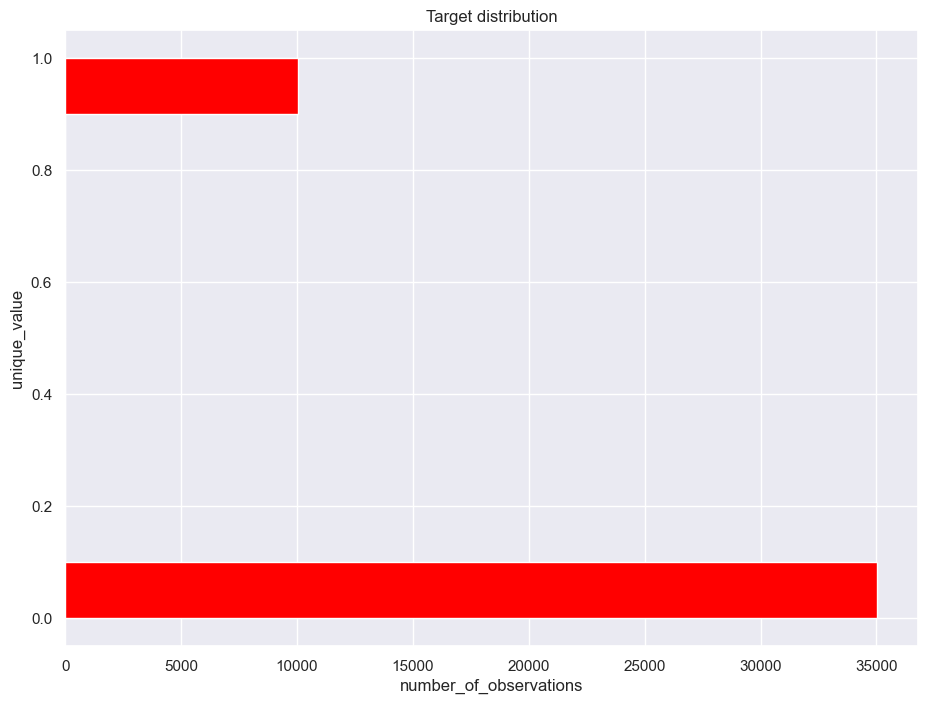

In [48]:
ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of the target:")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

SLet's separate the input variable names by excluding the target:

In [49]:
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

Let's use the function to replace *NaN* values:

In [50]:
table = fill_nan(data)

Let's separate the target variable and input features:

In [51]:
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

## 1.2. Bootstrapping

We will make an interval estimate of the average age for the customers who delayed repayment at the 90% confidence level. We use the example from the article as reference, if needed. We also use `np.random.seed(0)` as before. Will we find the resulting interval estimate.


In [52]:
def get_bootstrap_sample(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2.0, 100 * (1 -alpha / 2.0)])
    return boundaries

problem_client = data.loc[
    data['SeriousDlqin2yrs'] == 1, 'age'
].values

good_client = data.loc[
    data['SeriousDlqin2yrs'] == 0, 'age'
].values

np.random.seed(0)

problem_mean_age = [
    np.mean(sample) for sample in get_bootstrap_sample(problem_client, 1000)
]

good_mean_age = [
    np.mean(sample) for sample in get_bootstrap_sample(good_client, 1000)
]

print('average age for the customers who delayed repayment', stat_intervals(problem_mean_age, 0.1))
print('average age for the customers who do not delayed repayment', stat_intervals(good_mean_age, 0.1))

average age for the customers who delayed repayment [45.71379414 46.12700479]
average age for the customers who do not delayed repayment [52.59470132 52.85480064]


## 1.3. Logistic regression

Let's set up to use logistic regression:

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Now, we will create a `LogisticRegression` model and use `class_weight='balanced'` to make up for our unbalanced classes.

In [62]:
lr = LogisticRegression(random_state=5, class_weight="balanced")

Let's try to find the best regularization coefficient, which is the coefficient `C` for logistic regression. Then, we will have an optimal model that is not overfit and is a good predictor of the target variable.

In [63]:
parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}

In order to find the optimal value of `C`, let's apply stratified 5-fold validation and look at the *ROC AUC* against different values of the parameter `C`. Use the `StratifiedKFold` function for this:

In [64]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

One of the important metrics of model quality is the *Area Under the Curve (AUC)*. *ROC AUC* varies from 0 to 1. The closer ROC AUC is to 1, the better the quality of the classification model.

Let's perform a *Grid Search* with the scoring metric "roc_auc" for the parameter `C`. Let's determine which value of the parameter `C` is optimal.


In [68]:
grid_logit = GridSearchCV(
    lr,
    param_grid = parameters,
    cv = skf,
    n_jobs = -1,
    scoring = 'roc_auc'
)
grid_logit.fit(X, y)

grid_logit.best_params_

{'C': 0.001}

**Question 4.** Can we consider the best model stable? The model is *stable* if the standard deviation on validation is less than 0.5%. Save the *ROC AUC* value of the best model; it will be useful for the following tasks.


In [71]:
grid_logit.cv_results_["std_test_score"][1]

0.008137559189742445

The ROC AUC value of the best model:

In [69]:
grid_logit.best_score_

0.8089120626797153

## 1.4. Feature importance

*Feature importance* is defined by the absolute value of its corresponding coefficient. First, we need to normalize all of the feature values so that it will be valid to compare them. Let's determine which the most important feature for the best logistic regression model.


In [78]:
from sklearn.preprocessing import StandardScaler

lr = LogisticRegression(C = 0.001, random_state = 5, class_weight = 'balanced')
scal = StandardScaler()
lr.fit(scal.fit_transform(X), y)

pd.DataFrame(
    {'feat': independent_columns_names, 'coef': lr.coef_.flatten().tolist()}
).sort_values(by = 'coef', ascending = False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.723427
3,NumberOfTimes90DaysLate,0.516788
4,NumberOfTime60-89DaysPastDueNotWorse,0.193558
6,NumberOfDependents,0.101443
2,DebtRatio,-0.024096
5,MonthlyIncome,-0.163146
0,age,-0.416702


Let's calculate how much `DebtRatio` affects our prediction using the [softmax function](https://en.wikipedia.org/wiki/Softmax_function). Let's find out what its value.


In [82]:
print((np.exp(lr.coef_[0]) / np.sum(np.exp(lr.coef_[0])))[2])

0.1142637528306527


Let's see how we can interpret the impact of our features. To do this, we recalculate the logistic regression with absolute values, that is without scaling. Then we will change the customer's age by adding 20 years, keeping the other features unchanged. Let's determine how many times will the chance that the customer will not repay their debt increase.


In [84]:
lr = LogisticRegression(C = 0.001, random_state = 5, class_weight = 'balanced')
lr.fit(X, y)

pd.DataFrame(
    {'feat': independent_columns_names, 'coef': lr.coef_.flatten().tolist()}
).sort_values(by='coef', ascending = False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.459534
3,NumberOfTimes90DaysLate,0.403877
4,NumberOfTime60-89DaysPastDueNotWorse,0.236468
6,NumberOfDependents,0.163540
2,DebtRatio,-0.000004
5,MonthlyIncome,-0.000011
0,age,-0.013189


In [85]:
np.exp(lr.coef_[0][0] * 20)

0.7681480343643818

## 1.5. Random Forest

Importing the Random Forest classifier:

In [86]:
from sklearn.ensemble import RandomForestClassifier

Initialize Random Forest with 100 trees and balance target classes:

In [87]:
rf = RandomForestClassifier(
    n_estimators=100, n_jobs=-1, random_state=42, class_weight="balanced"
)

We will search for the best parameters among the following values:

In [88]:
parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

Also, we will use the stratified k-fold validation again. We should still have the `skf` variable.

Let's see how much higher is the *ROC AUC* of the best random forest model than that of the best logistic regression on validation.


In [89]:
grid_forest = GridSearchCV(
    rf,
    param_grid = parameters,
    cv = skf,
    n_jobs = -1,
    scoring = 'roc_auc'
)
grid_forest.fit(X, y)

grid_forest.best_params_

{'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 9}

In [90]:
grid_forest.best_score_

0.8357785451032532

Let's find which feature has the weakest impact in the Random Forest model.


In [93]:
grid_forest = GridSearchCV(
    rf,
    param_grid = {'max_depth': [10], 'max_features': [2], 'min_samples_leaf': [9]},
    cv = skf,
    n_jobs = -1,
    scoring = 'roc_auc'
)
perem_forest = grid_forest.fit(X, y)

Feature ranking:
1. NumberOfTime30-59DaysPastDueNotWorse 0.300290 
2. NumberOfTimes90DaysLate 0.278749 
3. NumberOfTime60-89DaysPastDueNotWorse 0.156534 
4. age 0.115860 
5. DebtRatio 0.076082 
6. MonthlyIncome 0.057994 
7. NumberOfDependents 0.014491 


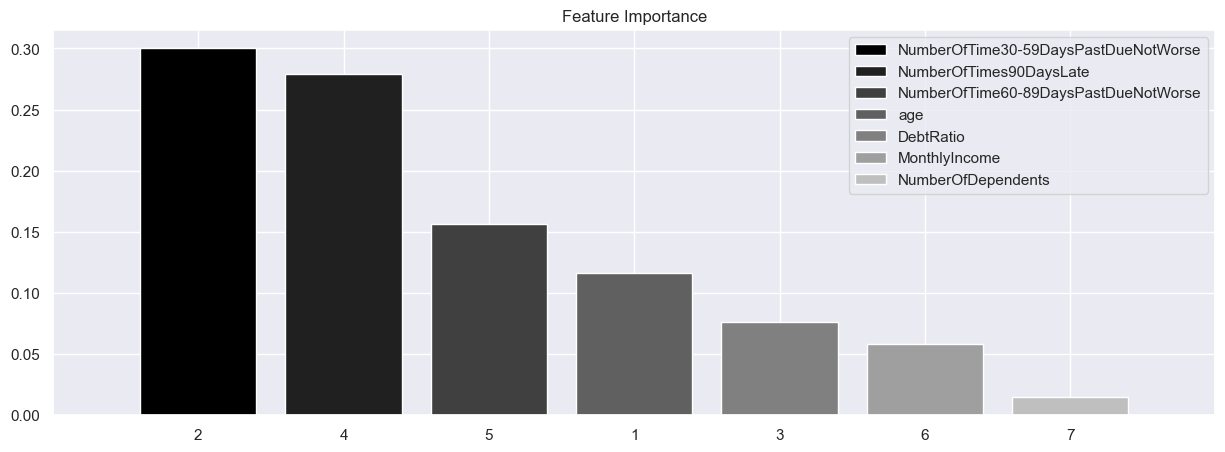

In [94]:
features = {
    "f1": u"age",
    "f2": u"NumberOfTime30-59DaysPastDueNotWorse",
    "f3": u"DebtRatio",
    "f4": u"NumberOfTimes90DaysLate",
    "f5": u"NumberOfTime60-89DaysPastDueNotWorse",
    "f6": u"MonthlyIncome",
    "f7": u"NumberOfDependents",
}


importances = perem_forest.best_estimator_.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 7
feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")

for f in range(num_to_plot):
    print(
        "%d. %s %f "
        % (f + 1, features["f" + str(feature_indices[f])], importances[indices[f]])
    )
plt.figure(figsize=(15, 5))
plt.title(u"Feature Importance")
bars = plt.bar(
    range(num_to_plot),
    importances[indices[:num_to_plot]],
    color=([str(i / float(num_to_plot + 1)) for i in range(num_to_plot)]),
    align="center",
)
ticks = plt.xticks(range(num_to_plot), feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u"".join(features["f" + str(i)]) for i in feature_indices]);

The weakest influence has: NumberOfDependents

The most significant advantage of using logistic regression compared to a random forest for this task is the interpretability of the function.

On the one hand, the random forest model is better suited for our creditworthiness assessment task. Its performance is 4% higher. The reason for this result is a small number of features and the compositional property of random forests.

On the other hand, the main advantage of logistic regression is that we can interpret the effect of the function on the model result.

## 1.6. Bagging

Import modules and set up the parameters for bagging:

In [104]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

parameters = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    
}

Let's compare a bagging classifier with `random_state=42`. For the base classifiers, use 100 logistic regressors and use `RandomizedSearchCV` instead of `GridSearchCV`. It will take a lot of time to iterate over all 54 variants, so set the maximum number of iterations for `RandomizedSearchCV` to 20. Don't forget to set the parameters `cv` and `random_state=1`.

Will we find the best *ROC AUC* that we have achieved.


In [105]:
bg = BaggingClassifier(
    LogisticRegression(class_weight = "balanced"),
    n_estimators = 100,
    n_jobs = -1,
    random_state = 42,
)
r_grid_search = RandomizedSearchCV(
    bg,
    parameters,
    n_jobs = -1,
    scoring = "roc_auc",
    cv = skf,
    n_iter = 20,
    random_state = 1,
    verbose = True,
)
r_grid_search = r_grid_search.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [106]:
r_grid_search.best_score_

0.8087745786752851

Let's give an interpretation of the best parameters for bagging. Why are these values of `max_features` and `max_samples` the best?

The advantage of Random Forest is that the trees in the composition are not highly correlated. Similarly, for bagging with logistic regression, the weaker correlation between single models, the higher the accuracy. Since in logistic regression there is almost no randomness, we have to change the set of features to minimize the correlation between our single models.